In [142]:
import json
import requests
from attrdict import AttrDict

In [143]:
def to_camel_case(snake_str):
    components = snake_str.split('_')
    # We capitalize the first letter of each component except the first one
    # with the 'title' method and join them together.
    return ''.join(x.title() for x in components)



In [144]:
r = requests.get("https://s3.amazonaws.com/dictionary-artifacts/dcfdictionary/3.1.2/schema.json")
crdc = AttrDict(r.json())

crdc_entities = {}
for k, e in crdc.items():
    if 'id' in e and 'properties' in e:
        crdc_entities[to_camel_case(e['id'])] = [k for k in e['properties'].keys() if k != '$ref']


In [147]:

with open('gdc.json') as ins:
    gdc = json.load(ins)

gdc_entities = {}
for k, e in gdc.items():
    if 'id' in e and 'properties' in e:
        gdc_entities[to_camel_case(e['id'])] = [k for k in e['properties'].keys() if k != '$ref']

# xform        
gdc_entities['Subject'] = gdc_entities['Case']
del gdc_entities['Case']



In [148]:
r = requests.get('https://pdc.esacinc.com/graphql?query={ __schema { types { name kind fields { name } } } }')
pdc = r.json()

# xform 
pdc_entities = {t['name'].replace('UI',''): [f['name'] for f in t['fields']] for t in pdc['data']['__schema']['types'] if t['kind'] == 'OBJECT' and not t['name'].startswith('_')}
pdc_entities['Subject'] = pdc_entities['Case']
del pdc_entities['Case']

pdc_entities['Study'] = pdc_entities['Experiment']
del pdc_entities['Experiment']


In [149]:

projects = {
    'pdc': pdc_entities,
    'gdc': gdc_entities,
    'crdc': crdc_entities,    
}


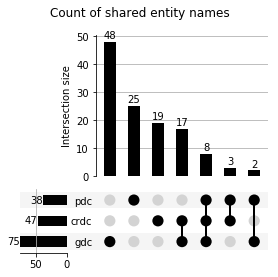

In [150]:
import matplotlib.pyplot
import pandas
import upsetplot

project_df =  pandas.DataFrame(upsetplot.from_contents({project: entities.keys() for project, entities in projects.items()}))


upsetplot.plot(project_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Count of shared entity names')
current_figure.savefig("cda_entity.png")


In [151]:
# from collections import defaultdict
# entity_by_project = defaultdict(set)
# for project, entities in projects.items():
#     for k in entities:
#         entity_by_project[k].add(project)

# entity_df =  pandas.DataFrame(upsetplot.from_contents(entity_by_project))

# upsetplot.plot(entity_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
# current_figure = matplotlib.pyplot.gcf()
# current_figure.set_size_inches(10.5, 40.5)
# current_figure.suptitle('Count of shared project names')
# current_figure.savefig("cda_project.png")

In [160]:
from collections import defaultdict


def similarity(project_subset, entity):
    fields = set()
    for p in project_subset:
        for f in projects[p][entity]:
            if f.endswith('_datetime'):
                continue
            fields.add(f)
    found_in_all = 0
    # print('e',entity)
    for f in fields:
        found = 0
        for p in project_subset:
            if f in projects[p][entity]:
                found += 1
                # print('hit', p, f)
            # else:
                # print('miss', p, f)

        if found == len(project_subset):
            found_in_all +=1
    percentage_match = int(found_in_all * 100 / len(fields))
    if percentage_match == 100:
        return ''
    return '({}%)'.format(percentage_match)
    


entity_by_project = defaultdict(set)
for project, entities in projects.items():
    for k in entities:
        entity_by_project[k].add(project)


found_in = defaultdict(set)
for k, v in entity_by_project.items():
    found_in[','.join(v)].add(k)

print('Projects with entities in common (field match %):')    
for k in sorted(found_in, key = len, reverse= True):
    matched_projects = k.split(',')
    if len(matched_projects) == 1:
        continue
    print(k)
    for v in sorted(found_in[k]):
        print('  ','*', v, similarity(matched_projects,v))

print('Projects with unique entities:')    
for k in sorted(found_in, key = len, reverse= True):
    matched_projects = k.split(',')
    if len(matched_projects) > 1:
        continue
    print(k)
    for v in sorted(found_in[k]):
        print('  ','*', v, similarity(matched_projects,v))
            

Projects with entities in common (field match %):
gdc,pdc,crdc
   * Aliquot (14%)
   * Demographic (31%)
   * Diagnosis (30%)
   * Program (9%)
   * Project (3%)
   * Publication (0%)
   * Sample (46%)
   * Subject (6%)
pdc,crdc
   * Protocol (42%)
   * Study (6%)
   * StudyRunMetadata (25%)
gdc,crdc
   * AlignedReads (23%)
   * AlignedReadsIndex (27%)
   * AlignmentCocleaningWorkflow (36%)
   * AlignmentWorkflow (36%)
   * CopyNumberEstimate (26%)
   * CopyNumberSegment (22%)
   * CopyNumberVariationWorkflow (20%)
   * FollowUp (6%)
   * GeneExpression (25%)
   * ProteinExpression (30%)
   * ReadGroup (79%)
   * ReadGroupQc (70%)
   * RnaExpressionWorkflow (38%)
   * SubmittedAlignedReads (27%)
   * SubmittedGenomicProfile (27%)
   * SubmittedUnalignedReads (31%)
   * Treatment (23%)
gdc,pdc
   * Clinical (10%)
   * File (8%)
Projects with unique entities:
crdc
   * Acknowledgement 
   * AggregatedGenotypingArray 
   * CoreMetadataCollection 
   * DrugAttribute 
   * DrugResponse 
   

In [155]:
{project: entities['Subject'] for project, entities in projects.items()}

{'pdc': ['aliquot_id',
  'sample_id',
  'case_id',
  'case_submitter_id',
  'aliquot_submitter_id',
  'case_status',
  'aliquot_status',
  'sample_status',
  'sample_submitter_id',
  'program_name',
  'project_name',
  'sample_type',
  'disease_type',
  'primary_site'],
 'gdc': ['days_to_lost_to_followup',
  'disease_type',
  'updated_datetime',
  'created_datetime',
  'index_date',
  'tissue_source_sites',
  'lost_to_followup',
  'state',
  'primary_site',
  'submitter_id',
  'batch_id',
  'project_id',
  'type',
  'id',
  'projects'],
 'crdc': ['updated_datetime',
  'index_date',
  'tissue_source_site_code',
  'submitter_id',
  'days_to_lost_to_followup',
  'species',
  'disease_type',
  'created_datetime',
  'type',
  'breed',
  'id',
  'lost_to_followup',
  'state',
  'primary_site',
  'project_id',
  'studies']}

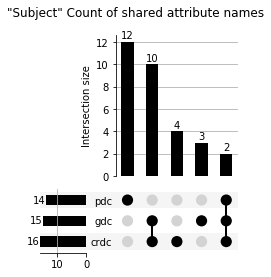

In [156]:
import matplotlib.pyplot
import pandas
import upsetplot



project_df =  pandas.DataFrame(upsetplot.from_contents({project: entities['Subject'] for project, entities in projects.items()}))


upsetplot.plot(project_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('"Subject" Count of shared attribute names')
current_figure.savefig("cda_subject_entity.png")


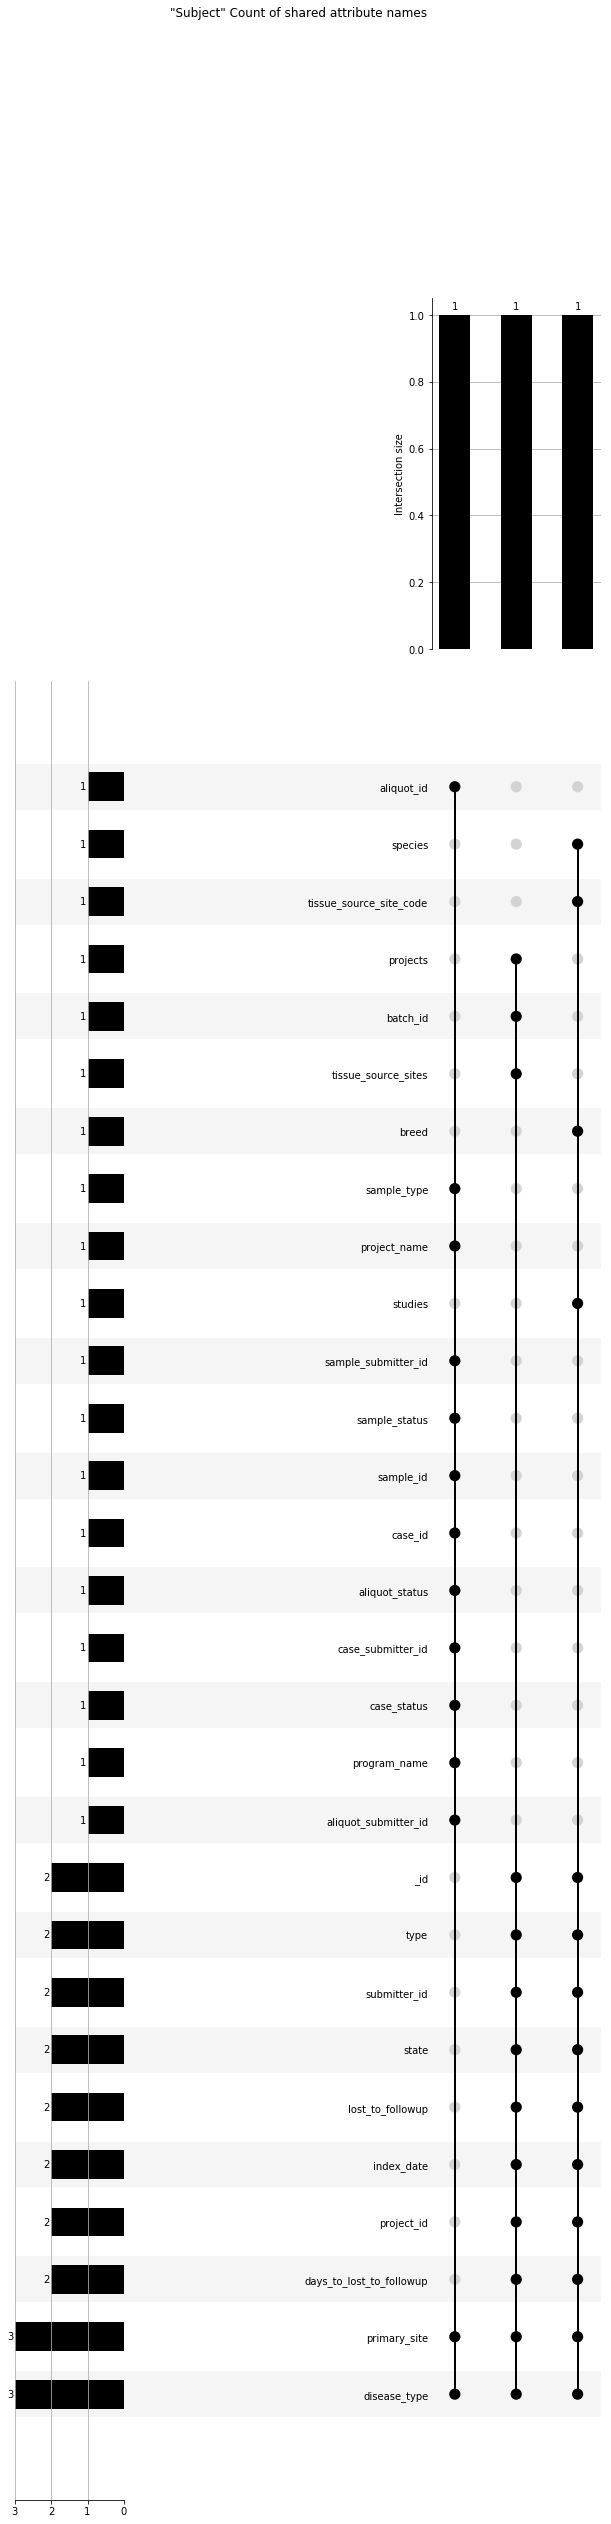

In [164]:

from collections import defaultdict
entity_by_project = defaultdict(set)

for project, entities in projects.items():
    for k in entities['Subject']:
        if k.endswith('_datetime'):
            continue

        if k == 'id':
            k = '_id'
        entity_by_project[k].add(project)

entity_df =  pandas.DataFrame(upsetplot.from_contents(entity_by_project))

upsetplot.plot(entity_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.set_size_inches(10.5, 40.5)
current_figure.suptitle('"Subject" Count of shared attribute names')
current_figure.savefig("cda_subject_entity.png")


In [165]:
entity_df

id
aliquot_id sample_id case_id case_submitter_id aliquot_submitter_id case_status aliquot_status sample_status sample_submitter_id program_name project_name sample_type disease_type primary_site days_to_lost_to_followup index_date tissue_source_sites lost_to_followup state submitter_id batch_id project_id type  _id   projects tissue_source_site_code species breed studies      
True       True      True    True              True                 True        True           True          True                True         True         True        True         True         False                    False      False               False            False False        False    False      False False False    False                   False   False False     pdc
False      False     False   False             False                False       False          False         False               False        False        False       True         True         True                     True       True                True             True  True         True     True       True  True  True     False                   False   False False     gdc
                                                                                                                                                                                                                                     False               True             True  True         False    True       True  True  False    True                    True    True  True     crdc

In [207]:
records = project_df.to_records('dict')

fields = [f for f in records.dtype.fields]

fields_by_project = [AttrDict({k:v for k, v in zip(fields, r)}) for r in records]

for f in sorted([f.id for f in fields_by_project if f.gdc]):
    print(f)

batch_id
created_datetime
days_to_lost_to_followup
disease_type
id
index_date
lost_to_followup
primary_site
project_id
projects
state
submitter_id
tissue_source_sites
type
updated_datetime


In [ ]:
```
https://services.cancerimagingarchive.net/services/v3/TCIA/query/getPatientStudy/metadata?api_key=76a553ad-1208-40db-b2ee-20e0edead0c8
     
```